# NDVI SAVI Change Detection for Archaeological Monitoring
This notebook is part of a broader project focused on montoring archaeological landscapes potentially affected by human or environmental impacts. The purpose of this analysis is to identify vegetation change over time as a possible signal of erosion, destabsalization, or disturbance. Sentinel-2 imagery is used to calculate:

- **NDVI** (Normalized Difference Vegetation Index)
- **SAVI** (Soil Adjusted Vegetation Index)

Both indices are generated externally (e.g. in QGIS) using red and near-infrared bands, and the processed rasters are used here for analysis. These can be replicated for any site where disturbance monitoring is required. 

## Project Scope
This example demonstrates analysis for one site (5HF737), with the assumption that additional site folders (e.g., `5LA13450`, `5LA04776`) can be added using the same workflow. The monitored sites differ in terrain and vegetation types and are located within a known corridor. (e.g., low-level flight paths).
## Notebook Workflow 
This notebook includes:
- Loading NDVI and SAVI rasters for two time points (e.g. March 2024 and March 2025).
- Raster differencing to detect significant vegetation change.
- A brief discussion on how results can support a machine learning pipeline for long-term monitoring.
  
> **Note:** This notebook contains no geospatial data tied to archaelogical site coordinates. All input rasters must be prepared externally. 


## Getting Started

To use this notebook, you must first calculate NDVI and SAVI rasters for your site using a GIS application such as QGIS or ArcGIS Pro. This notebook assumes that the rasters have already been processed, georeferenced, clipped to a common extent, and exported in a compatible format (e.g., GeoTIFF). Once those rasters are prepared, you can assign their file paths to the variables in the next section to begin the analysis.

No prior coding experience is required to follow the workflow, as long as the input files are in place.

### Required Inputs:
- NDVI raster for Time 1 (e.g., March 2024)
- NDVI raster for Time 2 (e.g., March 2025)
- SAVI raster for Time 1
- SAVI raster for Time 2

> ⚠️ **Note:** This notebook currently includes data only for **site 5HF737**. To apply the workflow to a different site, you will need to generate and provide equivalent NDVI and SAVI rasters for that location, following the same directory structure and file naming conventions.

In [1]:
import os                     # for path handling
import numpy as np            # for raster math
import matplotlib.pyplot as plt  # for visualization
import rasterio               # to read rasters
from rasterio.plot import show  # for basic raster plots
import matplotlib.colors as colors  # optional for advanced colormap control
import warnings
warnings.filterwarnings('ignore')

## Input Raster File Setup

This notebook expects the following raster inputs, all of which should be:

- Georeferenced
- Clipped to the same spatial extent
- Projected in the same coordinate reference system (CRS)

### Required Files:
- **NDVI raster for Time 1** (e.g., March 2024)
- **NDVI raster for Time 2** (e.g., March 2025)
- **SAVI raster for Time 1**
- **SAVI raster for Time 2**

These files should be organized within the appropriate site folder (e.g., `data/5HF737/ndvi_by_month/`) and named in a consistent format. This ensures compatibility with the code blocks that follow.


In [2]:
import os

# Define base directory for site data
site_id = "5HF737"
base_data_dir = os.path.join("..", "data", site_id)

# NDVI Rasters
ndvi_dir = os.path.join(base_data_dir, "ndvi_by_month")
ndvi_time1_path = os.path.join(ndvi_dir, "NDVI_2024-march.tif")
ndvi_time2_path = os.path.join(ndvi_dir, "NDVI_2025-march.tif")

# SAVI Rasters
savi_dir = os.path.join(base_data_dir, "savi_by_month")
savi_time1_path = os.path.join(savi_dir, "SAVI_2024-march.tif")
savi_time2_path = os.path.join(savi_dir, "SAVI_2025-march.tif")


## Load Raster Data

This section loads the NDVI and SAVI rasters using `rasterio`. Each raster is opened as a NumPy array, and its associated metadata (e.g., coordinate reference system, affine transform) is stored for later use.

These data will form the basis for raster differencing to detect vegetation change over time.

In [3]:
# NDVI
with rasterio.open(ndvi_time1_path) as src:
    ndvi_t1 = src.read(1)
    ndvi_meta = src.meta  # Save metadata for future use

with rasterio.open(ndvi_time2_path) as src:
    ndvi_t2 = src.read(1)

# SAVI
with rasterio.open(savi_time1_path) as src:
    savi_t1 = src.read(1)

with rasterio.open(savi_time2_path) as src:
    savi_t2 = src.read(1)

## Test Raster Loading with Plots

The plots below visually confirm that each raster has been loaded correctly. This is useful for verifying that the files are readable, properly georeferenced, and contain expected data.

You should see a meaningful distribution of vegetation values (typically between 0 and 1 for NDVI and SAVI).

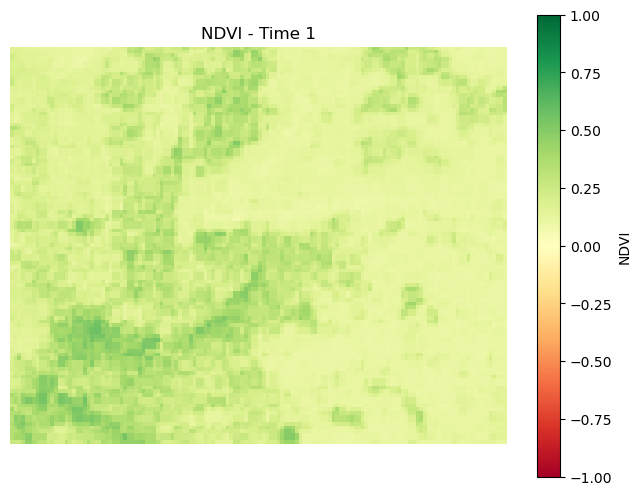

In [4]:
# Quick plot of NDVI Time 1
plt.figure(figsize=(8, 6))
plt.imshow(ndvi_t1, cmap='RdYlGn', vmin=-1, vmax=1)
plt.colorbar(label='NDVI')
plt.title("NDVI - Time 1")
plt.axis('off')
plt.show()

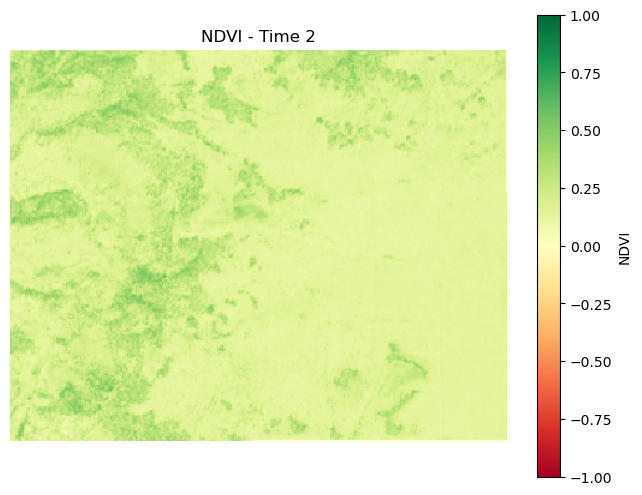

In [5]:
# Quick plot of NDVI Time 2
plt.figure(figsize=(8, 6))
plt.imshow(ndvi_t2, cmap='RdYlGn', vmin=-1, vmax=1)
plt.colorbar(label='NDVI')
plt.title("NDVI - Time 2")
plt.axis('off')
plt.show()

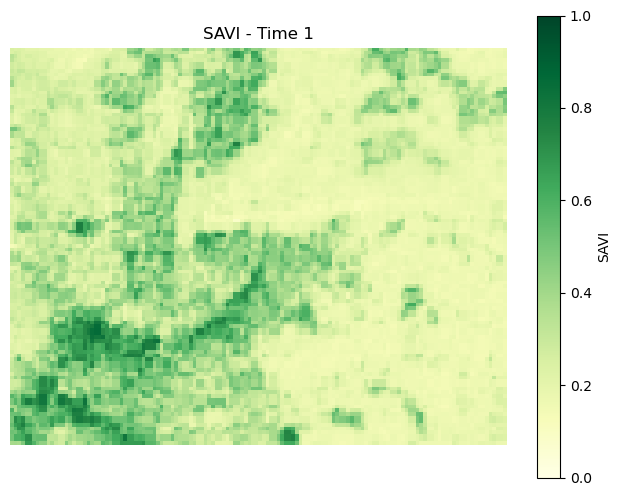

In [6]:
plt.figure(figsize=(8, 6))
plt.imshow(savi_t1, cmap='YlGn', vmin=0, vmax=1)
plt.colorbar(label='SAVI')
plt.title("SAVI - Time 1")
plt.axis('off')
plt.show()

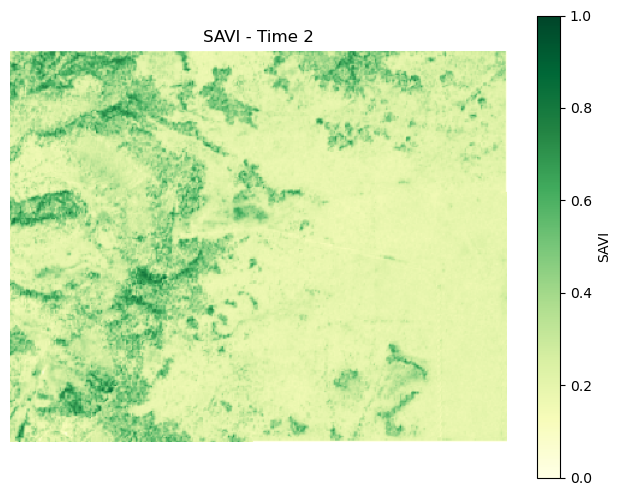

In [7]:
plt.figure(figsize=(8, 6))
plt.imshow(savi_t2, cmap='YlGn', vmin=0, vmax=1)
plt.colorbar(label='SAVI')
plt.title("SAVI - Time 2")
plt.axis('off')
plt.show()

## Vegetation Index Differencing

To detect vegetation change over a one-year period, we computed the difference between NDVI and SAVI rasters from March 2024 (Time 1) and March 2025 (Time 2). Both indices were masked to exclude areas where slope exceeds 30°, focusing the analysis on relatively stable terrain.

The difference is calculated as:

- **NDVI Difference** = NDVI (2025) − NDVI (2024)
- **SAVI Difference** = SAVI (2025) − SAVI (2024)

These difference rasters highlight areas of vegetation gain (positive values) or loss (negative values) and can be used to identify potential disturbances or environmental changes. They are visualized using a diverging color scale and exported as GeoTIFFs for use in further analysis or integration with machine learning models.

In [8]:
print("NDVI Time 1 shape:", ndvi_t1.shape)
print("NDVI Time 2 shape:", ndvi_t2.shape)

NDVI Time 1 shape: (109, 136)
NDVI Time 2 shape: (315, 399)


**Note:** This version of the notebook includes a resampling step to align the NDVI rasters. This was necessary because the 2024 and 2025 rasters were derived from different base layers and had slightly different pixel grids. For the final version used in the SAA 2025 poster, this issue has been resolved — both rasters are clipped and aligned to a common extent and resolution. Resampling is included here to maintain a functional workflow with the current input files.

In [9]:
from rasterio.warp import reproject, Resampling

def resample_to_match(source_array, source_transform, target_shape, target_transform, source_crs, target_crs):
    """Resample a raster array to match the shape, transform, and CRS of a target raster."""
    resampled = np.empty(target_shape, dtype=source_array.dtype)
    
    reproject(
        source=source_array,
        destination=resampled,
        src_transform=source_transform,
        src_crs=source_crs,
        dst_transform=target_transform,
        dst_crs=target_crs,
        resampling=Resampling.bilinear  # Use bilinear for NDVI; can switch to nearest for categorical
    )
    
    return resampled

In [10]:
# Re-open ndvi_time2 to get its metadata
with rasterio.open(ndvi_time2_path) as src:
    ndvi_t2_resampled = resample_to_match(
        source_array=src.read(1),
        source_transform=src.transform,
        target_shape=ndvi_t1.shape,
        target_transform=ndvi_meta['transform'],
        source_crs=src.crs,
        target_crs=ndvi_meta['crs']
    )

In [15]:
with rasterio.open(savi_time2_path) as src:
    savi_t2_raw = src.read(1)
    savi_t2_resampled = resample_to_match(
        source_array=savi_t2_raw,
        source_transform=src.transform,
        target_shape=savi_t1.shape,
        target_transform=ndvi_meta['transform'],  # Use the same transform as NDVI if SAVI_t1 doesn't have its own metadata
        source_crs=src.crs,
        target_crs=ndvi_meta['crs']
    )

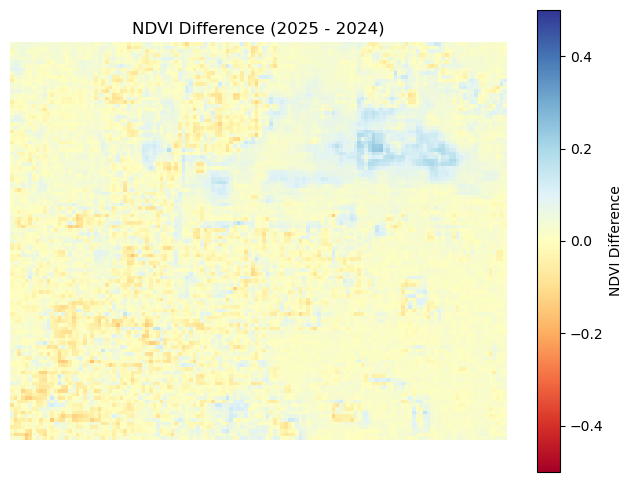

In [16]:
# Compute NDVI difference (Time 2 - Time 1)
ndvi_diff = ndvi_t2_resampled - ndvi_t1

# Visualize the NDVI difference map
plt.figure(figsize=(8, 6))
plt.imshow(ndvi_diff, cmap='RdYlBu', vmin=-0.5, vmax=0.5)
plt.colorbar(label='NDVI Difference')
plt.title("NDVI Difference (2025 - 2024)")
plt.axis('off')
plt.show()


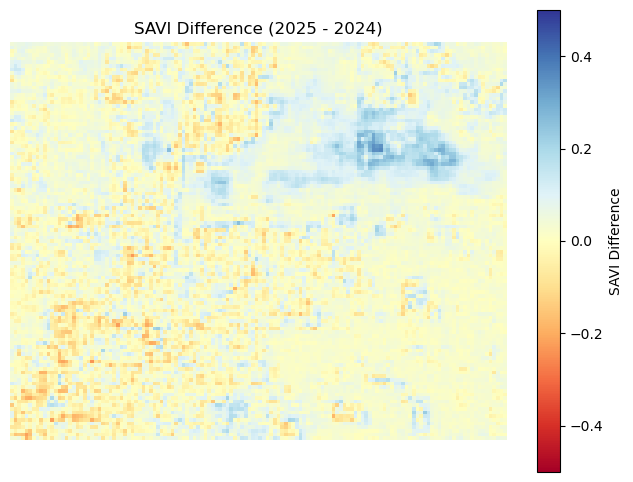

In [18]:
# Compute SAVI difference (Time 2 - Time 1)
savi_diff = savi_t2_resampled - savi_t1

# Visualize the SAVI difference map
plt.figure(figsize=(8, 6))
plt.imshow(savi_diff, cmap='RdYlBu', vmin=-0.5, vmax=0.5)
plt.colorbar(label='SAVI Difference')
plt.title("SAVI Difference (2025 - 2024)")
plt.axis('off')
plt.show()

## Exporting Difference Rasters

The NDVI and SAVI difference rasters are exported as GeoTIFFs for use in further analysis, including potential machine learning classification in a separate notebook. Each raster retains the geospatial metadata from the original NDVI input and is compressed using LZW to reduce file size.

### Exported Files:
- `ndvi_diff_2025_2024.tif`
- `savi_diff_2025_2024.tif`

These outputs are saved in the following directory:./data/5HF737/diff_outputs/


In [20]:
# Define output directory
output_dir = os.path.join("..", "data", site_id, "diff_outputs")
os.makedirs(output_dir, exist_ok=True)

# Define output filenames
ndvi_diff_path = os.path.join(output_dir, "ndvi_diff_2025_2024.tif")
savi_diff_path = os.path.join(output_dir, "savi_diff_2025_2024.tif")

# Export NDVI difference
with rasterio.open(
    ndvi_diff_path, "w",
    driver="GTiff",
    height=ndvi_diff.shape[0],
    width=ndvi_diff.shape[1],
    count=1,
    dtype=ndvi_diff.dtype,
    crs=ndvi_meta['crs'],
    transform=ndvi_meta['transform'],
    compress="LZW"
) as dst:
    dst.write(ndvi_diff, 1)

# Export SAVI difference
with rasterio.open(
    savi_diff_path, "w",
    driver="GTiff",
    height=savi_diff.shape[0],
    width=savi_diff.shape[1],
    count=1,
    dtype=savi_diff.dtype,
    crs=ndvi_meta['crs'],  # Assuming you used NDVI meta for both
    transform=ndvi_meta['transform'],
    compress="LZW"
) as dst:
    dst.write(savi_diff, 1)

In [21]:
print("Exported NDVI difference to:", ndvi_diff_path)
print("Exported SAVI difference to:", savi_diff_path)

Exported NDVI difference to: ..\data\5HF737\diff_outputs\ndvi_diff_2025_2024.tif
Exported SAVI difference to: ..\data\5HF737\diff_outputs\savi_diff_2025_2024.tif
